## 3-Way ANOVA

The three-way ANOVA is an extension of the two-way ANOVA for assessing whether there is an interaction effect between three independent categorical variables on a continuous outcome variable.

We’ll use the **headache dataset** [datarium package], which contains the measures of migraine headache episode pain score in 72 participants treated with three different treatments. The participants include 36 males and 36 females. Males and females were further subdivided into whether they were at low or high risk of migraine.

We want to understand how each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.

                            mean       std
gender risk treatment                     
female high X          78.865059  5.316489
            Y          81.175304  4.619387
            Z          81.035142  3.984886
       low  X          74.156231  3.690272
            Y          68.361925  4.081842
            Z          69.779555  2.719645
male   high X          92.738847  5.116095
            Y          82.341542  5.000898
            Z          79.680736  4.045885
       low  X          76.051783  3.854876
            Y          73.138772  4.765061
            Z          74.455863  4.888865
Shapiro-Wilk (Normality): ShapiroResult(statistic=np.float64(0.9821218558347049), pvalue=np.float64(0.39807840029789815))
Levene (Homogeneity): LeveneResult(statistic=np.float64(0.17859528084995452), pvalue=np.float64(0.9982136500456728))

Three-Way ANOVA:
                                      sum_sq    df            F        PR(>F)
Intercept                       37318.184764   1.0  1928.766332

<Figure size 1000x600 with 0 Axes>

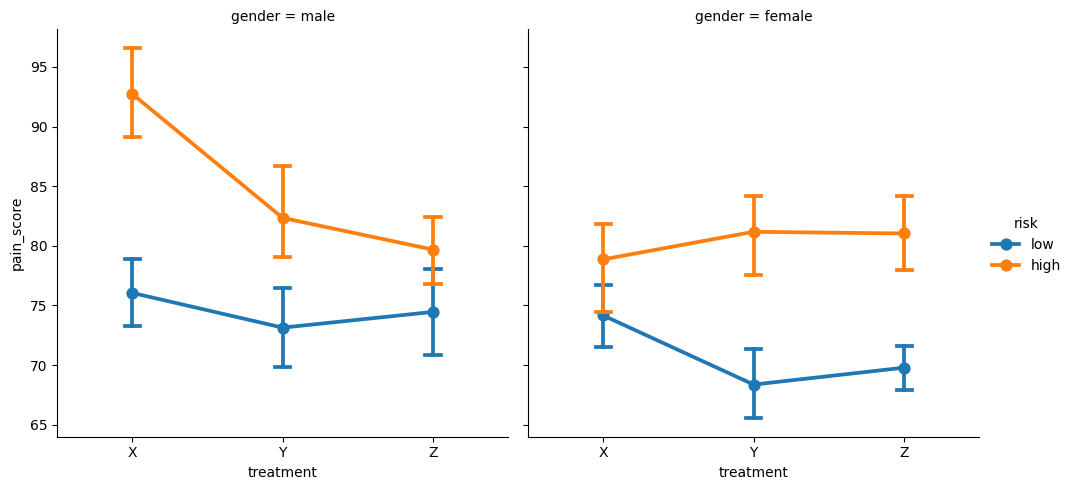

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. data
df = pd.read_csv('headache.csv')

# 2. descriptive statistics
print(df.groupby(['gender', 'risk', 'treatment'])['pain_score'].agg(['mean', 'std']))

# 3. assumptions Check
# normality
model = ols('pain_score ~ C(gender) * C(risk) * C(treatment)', data=df).fit()
print("Shapiro-Wilk (Normality):", stats.shapiro(model.resid))

# homogeneity
groups = [group['pain_score'].values for name, group in df.groupby(['gender', 'risk', 'treatment'])]
print("Levene (Homogeneity):", stats.levene(*groups))

# 4. 3 way ANOVA
anova_table = sm.stats.anova_lm(model, typ=3)
print("\nThree-Way ANOVA:")
print(anova_table)

# 5. post-hoc aalysis
# significant 3-way interaction found. decomposing by Gender.

# --- MALES ---
male_df = df[df['gender'] == 'male']
model_male = ols('pain_score ~ C(risk) * C(treatment)', data=male_df).fit()
print("\n2way ANOVA (Males):")
print(sm.stats.anova_lm(model_male, typ=3))

# significant 2-way interaction in Males. decomposing by Risk.
# --- Male, High Risk ---
male_high = male_df[male_df['risk'] == 'high']
print("\n1-Way ANOVA (Male, High Risk):")
model_male_high = ols('pain_score ~ C(treatment)', data=male_high).fit()
print(sm.stats.anova_lm(model_male_high, typ=2))

# pairwise comparisons for Male High Risk
tukey = pairwise_tukeyhsd(endog=male_high['pain_score'], groups=male_high['treatment'], alpha=0.05)
print("\nTukey HSD (Male, High Risk):")
print(tukey)

# 6. visualization
plt.figure(figsize=(10, 6))
sns.catplot(x="treatment", y="pain_score", hue="risk", col="gender", kind="point", data=df, capsize=0.1)
plt.show()